## **Dimensionality Reduction Techniques in Face Recognition using SVM Classifier**
### **Data Science Analysis EP4130/PH6130 Project**
### **Authors -**


*   ### **Jaya Sree Tolety**
    ### AI23MTECH14007
    ### M.Tech(Artificial Intelligence)



*   ### **Manikanta Vallepu**

    ### AI20BTECH11014

    ### B.Tech(Artificial Intelligence)


In [ ]:
from time import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def fetch_dataset():
    dataset = fetch_lfw_people(min_faces_per_person=100)   # labelled faces in the wild data with users more than 100 faces

    return dataset


def fetch_data_details(dataset):
    n_samples, height, width = dataset.images.shape

    X = dataset.data
    n_features = X.shape[1]

    # the label to predict is the id of the person
    y = dataset.target
    target_names = dataset.target_names
    n_classes = target_names.shape[0]

    print("Total DATASET size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)

    return n_samples, height, width, X, n_features, y, target_names, n_classes


def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test


def dimensionality_reduction_PCA(n_components, X_train, height, width):
    print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, height, width))

    return pca, eigenfaces


def dimensionality_reduction_ICA(n_components, X_train, height, width):
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    t0 = time()
    ica = FastICA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = ica.components_.reshape((n_components, height, width))

    return ica, eigenfaces


def dimensionality_reduction_NMF(n_components, X_train, height, width):
    print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))
    t0 = time()
    nmf = NMF(n_components=n_components, init='nndsvda', tol=5e-3).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = nmf.components_.reshape((n_components, height, width))

    return nmf, eigenfaces


def dimensionality_reduction_LDA(n_components, X_train, y_train):
    print("Extracting the top %d fisherfaces from %d faces"% (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components).fit(X_train)

    lda = LDA().fit(pca.transform(X_train), y_train)
    print("done in %0.3fs" % (time() - t0))

    return lda, pca


def train_text_transform_Model(model, X_train, X_test):
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_model = model.transform(X_train)
    X_test_model = model.transform(X_test)
    print("done in %0.3fs" % (time() - t0))

    return X_train_model, X_test_model


def train_text_transform_LDA(lda, pca, X_train, X_test):
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_lda = lda.transform(pca.transform(X_train))
    X_test_lda = lda.transform(pca.transform(X_test))
    print("done in %0.3fs" % (time() - t0))

    return X_train_lda, X_test_lda


def classification_svc(X_train_model, y_train):
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_model, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    return clf


def prediction(model, data):
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = model.predict(data)
    print("done in %0.3fs" % (time() - t0))

    return y_pred


def print_report(y_test, y_pred, target_names, n_classes):
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


def plot_images(images, titles, height, width, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

    plt.show()


def plot_images_lda(pca, lda, titles, height, width, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pca.inverse_transform(lda.scalings_[:, i]).reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

    plt.show()


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


# def plot_confusion_matrix(y_true, y_pred, matrix_title):
#     """confusion matrix computation and display"""
#     plt.figure(figsize=(9, 9), dpi=100)
#
#     # use sklearn confusion matrix
#     cm_array = confusion_matrix(y_true, y_pred)
#     plt.imshow(cm_array[:-1, :-1], interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(matrix_title, fontsize=16)
#
#     cbar = plt.colorbar(fraction=0.046, pad=0.04)
#     cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
#
#     true_labels = np.unique(y_true)
#     pred_labels = np.unique(y_pred)
#     xtick_marks = np.arange(len(true_labels))
#     ytick_marks = np.arange(len(pred_labels))
#
#     plt.xticks(xtick_marks, true_labels, rotation=90)
#     plt.yticks(ytick_marks, pred_labels)
#     plt.tight_layout()
#     plt.ylabel('True label', fontsize=14)
#     plt.xlabel('Predicted label', fontsize=14)
#     plt.tight_layout()
#
#     plt.show()
#
#
#
# plot_confusion_matrix(y_test, y_pred, "matriz")

## **METHOD 1 : PRINCIPAL COMPONENT ANALYSIS (PCA)**

Total DATASET size:
n_samples: 1140
n_features: 2914
n_classes: 5
Extracting the top 150 eigenfaces from 855 faces
done in 0.215s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.038s
Fitting the classifier to the training set
done in 15.293s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in 0.048s
                   precision    recall  f1-score   support

     Colin Powell       0.91      0.94      0.92        64
  Donald Rumsfeld       0.96      0.78      0.86        32
    George W Bush       0.87      0.96      0.91       127
Gerhard Schroeder       0.96      0.79      0.87        29
       Tony Blair       0.93      0.82      0.87        33

         accuracy                           0.90       285
        macro avg       0.93      0.86      0.89       285
     weighted avg       0.91      0.90      0.90       285

[[ 60   0   4   0   0]
 [  0  25   5   1   1]
 [  5   

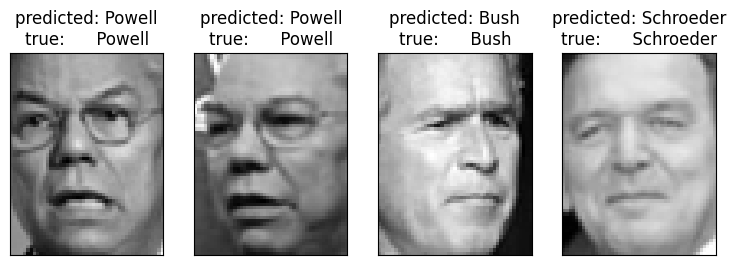

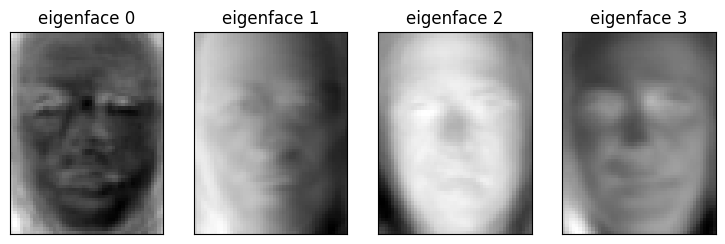

In [ ]:
# Load data
dataset = fetch_dataset()

# get dataset details and target names
n_samples, height, width, X, n_features, y, target_names, n_classes = fetch_data_details(dataset)

# split into a training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

# compute PCA
n_components = 150

pca, eigenfaces = dimensionality_reduction_PCA(n_components, X_train, height, width)

X_train_pca, X_test_pca = train_text_transform_Model(pca, X_train, X_test)

# Training a SVM classification model
clf = classification_svc(X_train_pca, y_train)

# Quantitative evaluation of the model quality on the test set
y_pred = prediction(clf, X_test_pca)

# printing classification report
print_report(y_test, y_pred, target_names, n_classes)

# printing images
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_images(X_test, prediction_titles, height, width)

# plot eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_images(eigenfaces, eigenface_titles, height, width)

## **METHOD 2 : Nonnegative Matrix Factorization (NMF)**

Total DATASET size:
n_samples: 1140
n_features: 2914
n_classes: 5
Extracting the top 150 eigenfaces from 855 faces
done in 0.711s
Projecting the input data on the eigenfaces orthonormal basis
done in 9.873s
Fitting the classifier to the training set
done in 19.765s
Best estimator found by grid search:
SVC(C=50000.0, class_weight='balanced', gamma=0.1)
Predicting people's names on the test set
done in 0.030s
                   precision    recall  f1-score   support

     Colin Powell       0.60      0.58      0.59        64
  Donald Rumsfeld       0.38      0.47      0.42        32
    George W Bush       0.73      0.78      0.75       127
Gerhard Schroeder       0.78      0.48      0.60        29
       Tony Blair       0.59      0.52      0.55        33

         accuracy                           0.64       285
        macro avg       0.61      0.56      0.58       285
     weighted avg       0.65      0.64      0.64       285

[[37  8 15  0  4]
 [ 7 15  7  0  3]
 [10 10 99  4  4]
 

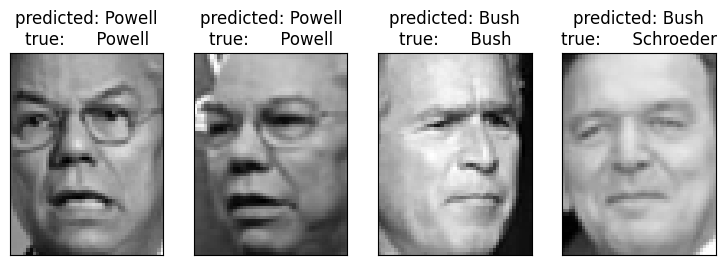

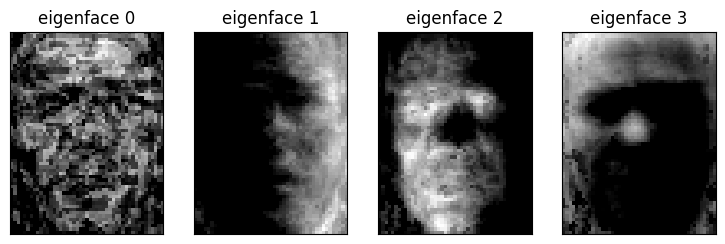

In [ ]:
# Load data
dataset = fetch_dataset()

# get dataset details and target names
n_samples, height, width, X, n_features, y, target_names, n_classes = fetch_data_details(dataset)

# split into a training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

# compute NMF
n_components = 150

nmf, eigenfaces = dimensionality_reduction_NMF(n_components, X_train, height, width)

X_train_nmf, X_test_nmf = train_text_transform_Model(nmf, X_train, X_test)

# Training a SVM classification model
clf = classification_svc(X_train_nmf, y_train)

# Quantitative evaluation of the model quality on the test set
y_pred = prediction(clf, X_test_nmf)

# printing classification report
print_report(y_test, y_pred, target_names, n_classes)


# printing images
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_images(X_test, prediction_titles, height, width)

# plot eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_images(eigenfaces, eigenface_titles, height, width)

## **METHOD 3 : Independent Component Analysis (ICA)**

Total DATASET size:
n_samples: 1140
n_features: 2914
n_classes: 5
Extracting the top 150 eigenfaces from 855 faces


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:729: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  self._fit_transform(X, compute_sources=False)


done in 2.365s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.027s
Fitting the classifier to the training set
done in 11.961s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting people's names on the test set
done in 0.050s
                   precision    recall  f1-score   support

     Colin Powell       0.88      0.89      0.88        64
  Donald Rumsfeld       0.79      0.81      0.80        32
    George W Bush       0.97      0.89      0.93       127
Gerhard Schroeder       0.70      0.90      0.79        29
       Tony Blair       0.82      0.82      0.82        33

         accuracy                           0.87       285
        macro avg       0.83      0.86      0.84       285
     weighted avg       0.88      0.87      0.88       285

[[ 57   2   1   2   2]
 [  2  26   1   2   1]
 [  5   3 113   4   2]
 [  1   0   1  26   1]
 [  0   2   1   3  27]]


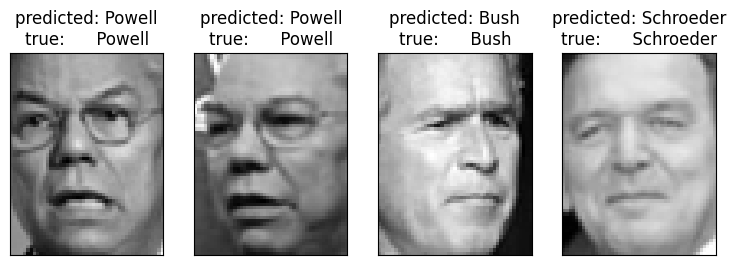

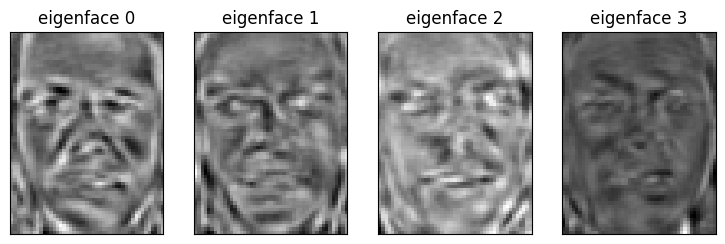

In [ ]:
# Load data
dataset = fetch_dataset()

# get dataset details and target names
n_samples, height, width, X, n_features, y, target_names, n_classes = fetch_data_details(dataset)

# split into a training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

# compute ICA
n_components = 150

ica, eigenfaces = dimensionality_reduction_ICA(n_components, X_train, height, width)

X_train_ica, X_test_ica = train_text_transform_Model(ica, X_train, X_test)

# Training a SVM classification model
clf = classification_svc(X_train_ica, y_train)

# Quantitative evaluation of the model quality on the test set
y_pred = prediction(clf, X_test_ica)

# printing classification report
print_report(y_test, y_pred, target_names, n_classes)


# printing images
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_images(X_test, prediction_titles, height, width)

# plot eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_images(eigenfaces, eigenface_titles, height, width)

## **METHOD 4 : Linear Discriminant Analysis (LDA)**

Total DATASET size:
n_samples: 1140
n_features: 2914
n_classes: 5
Extracting the top 150 fisherfaces from 855 faces
done in 0.354s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.034s
Fitting the classifier to the training set
done in 5.255s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Predicting people's names on the test set
done in 0.004s
                   precision    recall  f1-score   support

     Colin Powell       0.87      0.91      0.89        64
  Donald Rumsfeld       0.80      0.88      0.84        32
    George W Bush       0.98      0.86      0.92       127
Gerhard Schroeder       0.68      0.93      0.78        29
       Tony Blair       0.88      0.85      0.86        33

         accuracy                           0.88       285
        macro avg       0.84      0.88      0.86       285
     weighted avg       0.89      0.88      0.88       285

[[ 58   2   1   2   1]
 [  1  28   0   3   0]
 [  8  

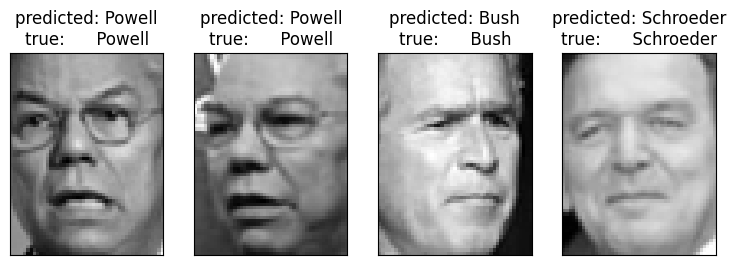

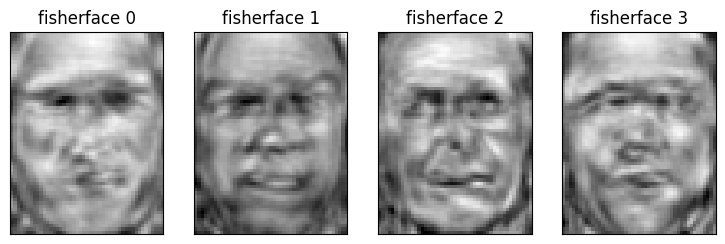

In [ ]:
# Load data
dataset = fetch_dataset()

# get dataset details and target names
n_samples, height, width, X, n_features, y, target_names, n_classes = fetch_data_details(dataset)

# split into a training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

# compute LDA
n_components = 150

lda, pca = dimensionality_reduction_LDA(n_components, X_train, y_train)

X_train_lda, X_test_lda = train_text_transform_LDA(lda, pca, X_train, X_test)

# Training a SVM classification model
clf = classification_svc(X_train_lda, y_train)

# Quantitative evaluation of the model quality on the test set
y_pred = prediction(clf, X_test_lda)

# printing classification report
print_report(y_test, y_pred, target_names, n_classes)

# printing images
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_images(X_test, prediction_titles, height, width)

# plot fisherfaces
fisherface_titles = ["fisherface %d" % i for i in range(4)]
plot_images_lda(pca, lda, fisherface_titles, height, width)